# Import libs

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

from tensorflow.keras.applications import Xception

from tensorflow.keras.callbacks import EarlyStopping


from sklearn.metrics import confusion_matrix, classification_report

# Mount Google drive

In [2]:
from google.colab import drive
from google.colab import output

In [3]:
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


# Change current working directory via "os.chdir"

In [4]:
print(Path.cwd())

/content


In [5]:
os.chdir("/content/drive/MyDrive/casting_product_classification")

In [6]:
path_parent = Path.cwd()
print(path_parent)

/content/drive/MyDrive/casting_product_classification


# Data preperation

In [7]:
train_generator = ImageDataGenerator(rescale=1.0/255, validation_split=0.3)

In [8]:
test_generator = ImageDataGenerator(rescale=1.0/255)

In [9]:
image_shape = (300, 300, 3)
batch_size = 32

## Train data

In [10]:
path_train_images = path_parent.joinpath("data/casting_data_300x300/train")

In [11]:
arg_train = {'target_size': image_shape[:2],
             'color_mode': 'rgb',
             'batch_size': batch_size,
             'class_mode':'binary',
             'shuffle': True}

In [12]:
train_set = train_generator.flow_from_directory(directory=path_train_images, subset='training', **arg_train)
val_set = train_generator.flow_from_directory(directory=path_train_images, subset='validation', **arg_train)

Found 4644 images belonging to 2 classes.
Found 1989 images belonging to 2 classes.


In [13]:
print(f"Class mapping: {train_set.class_indices}")
print(f"Number of samples in training set: {train_set.samples}")
print(f"Number of samples in validation set: {val_set.samples}")

Class mapping: {'def_front': 0, 'ok_front': 1}
Number of samples in training set: 4644
Number of samples in validation set: 1989


## Test data

In [14]:
path_test_images = path_parent.joinpath("data/casting_data_300x300/test")

In [15]:
arg_test = {'target_size': image_shape[:2],
            'color_mode': 'rgb',
            'batch_size': batch_size,
            'class_mode':'binary',
            'shuffle': False}

In [16]:
test_set = test_generator.flow_from_directory(directory=path_test_images, **arg_test)

Found 715 images belonging to 2 classes.


In [17]:
print(f"Class mapping: {test_set.class_indices}")
print(f"Number of samples in test set: {test_set.samples}")

Class mapping: {'def_front': 0, 'ok_front': 1}
Number of samples in test set: 715


# Create model

## Load Xception model pre-trained on ImageNet

In [18]:
xception_model = Xception(input_shape=image_shape,
                          include_top=False,
                          weights='imagenet')

83683744/83683744 [==============================] - 4s 0us/step


In [19]:
xception_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 300, 300, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 149, 149, 32)         864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 149, 149, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 149, 149, 32)         0         ['block1_conv1_bn[0][0]

## Customize the pre-trained model

In [20]:
def create_model(pre_train_model):
    # Set the parameters of the pre-trained model to be non-trainable
    for layer in pre_train_model.layers:
        layer.trainable = False

    # Create a new model based on the pre-trained model
    model = Sequential(pre_train_model)

    # Add some layer to the pre-trained model
    model.add(Flatten())
    model.add(Dense(units=256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model


In [23]:
model = create_model(xception_model)

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 flatten_1 (Flatten)         (None, 204800)            0         
                                                                 
 dense_2 (Dense)             (None, 256)               52429056  
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 73290793 (279.58 MB)
Trainable params: 52429313 (200.00 MB)
Non-trainable params: 20861480 (79.58 MB)
_________________________________________________________________


# Training

In [25]:
early_stop = EarlyStopping(monitor='val_loss', patience=4)

In [26]:
history = model.fit(train_set,
                    epochs=20,
                    validation_data=val_set,
                    callbacks=[early_stop])

Epoch 1/20
146/146 [==============================] - 2156s 14s/step - loss: 1.3651 - accuracy: 0.9248 - val_loss: 0.0383 - val_accuracy: 0.9894
Epoch 2/20
146/146 [==============================] - 55s 374ms/step - loss: 0.0259 - accuracy: 0.9944 - val_loss: 0.0188 - val_accuracy: 0.9940
Epoch 3/20
146/146 [==============================] - 55s 373ms/step - loss: 0.0324 - accuracy: 0.9914 - val_loss: 0.0350 - val_accuracy: 0.9910
Epoch 4/20
146/146 [==============================] - 60s 408ms/step - loss: 0.0207 - accuracy: 0.9931 - val_loss: 0.0182 - val_accuracy: 0.9945
Epoch 5/20
146/146 [==============================] - 55s 378ms/step - loss: 0.0130 - accuracy: 0.9966 - val_loss: 0.0271 - val_accuracy: 0.9920
Epoch 6/20
146/146 [==============================] - 55s 378ms/step - loss: 0.0216 - accuracy: 0.9927 - val_loss: 0.0274 - val_accuracy: 0.9915
Epoch 7/20
146/146 [==============================] - 55s 377ms/step - loss: 0.0187 - accuracy: 0.9944 - val_loss: 0.0172 - val_ac

In [27]:
df_history = pd.DataFrame(history.history)
df_history.head()

,loss,accuracy,val_loss,val_accuracy
0,1.365105,0.924849,0.038339,0.989442
1,0.025871,0.994401,0.018793,0.993967
2,0.032414,0.991387,0.035000,0.990950
3,0.020726,0.993109,0.018226,0.994470
4,0.012959,0.996555,0.027082,0.991956


<Axes: >

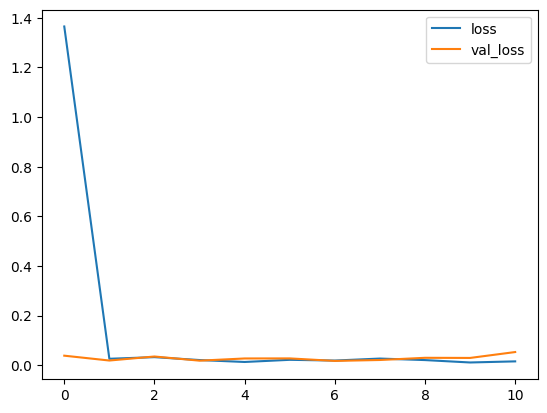

In [28]:
df_history[['loss', 'val_loss']].plot()

In [29]:
print(type(history.history))
print(history.history.keys())

<class 'dict'>
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


<Axes: >

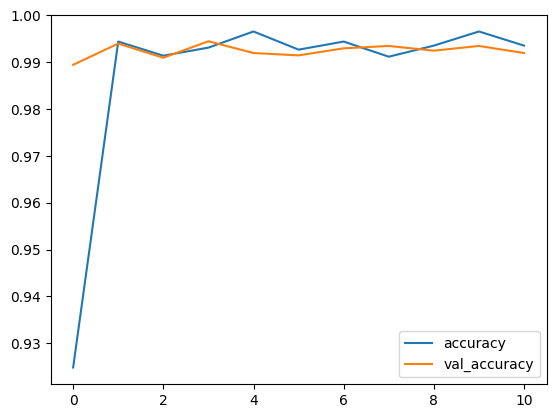

In [30]:
df_history[['accuracy', 'val_accuracy']].plot()

# Analyzing model performance

In [31]:
pred_probability = model.predict(test_set)

23/23 [==============================] - 484s 22s/step


In [32]:
predictions = pred_probability > 0.5

In [33]:
print(classification_report(y_true=test_set.classes, y_pred=predictions))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       453
           1       0.97      1.00      0.98       262

    accuracy                           0.99       715
   macro avg       0.99      0.99      0.99       715
weighted avg       0.99      0.99      0.99       715



In [34]:
print(confusion_matrix(y_true=test_set.classes, y_pred=predictions))

[[445   8]
 [  0 262]]


# Save the trained model

In [35]:
model.save('model_holder/xception_based_model.keras')